In [1]:
!pip install numdifftools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 1.8 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import subprocess
import warnings
import time
from tqdm import tqdm
import copy

import numpy as np
import scipy as sp
import scipy.optimize as opt
import numdifftools as nd
import matplotlib as mpl
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp


%matplotlib inline
eps = np.finfo(float).eps
np.random.seed(1)

DATA_DIR = Path("data")
if not DATA_DIR.exists():
    DATA_DIR.mkdir()

# Problem 1

## Part a

In [3]:
def f(i, x):
    return 3.5 * x * (1 - x)


def g(n, x):
    return jax.lax.fori_loop(0, n, f, x)

In [4]:
n_vals = [1, 10, 100, 1000]

for n_val in n_vals:
    g_prime = jax.grad(g, argnums=1)(n_val, 0.50)
    print(f"n = {n_val}:", g_prime)

n = 1: 0.0
n = 10: -1.7462298e-10
n = 100: -0.0
n = 1000: 0.0


## Part b

In [5]:
def f(theta, dims, x, sigma):
    """Neural network with a single hidden layer."""
    ni, no, nh = dims
    start_dim = 0
    W1 = theta[start_dim : (start_dim + nh * ni)].reshape((nh, ni))
    start_dim += nh * ni
    b1 = theta[start_dim : (start_dim + nh)]
    start_dim += nh
    W2 = theta[start_dim : (start_dim + no * nh)].reshape((no, nh))
    start_dim += no * nh
    b2 = theta[start_dim:]
    # Layer 1
    y = jnp.array([sigma(W1 @ xi + b1) for xi in x])
    # Output
    y = jnp.array([sigma(W2 @ yi + b2) for yi in y])
    return y.flatten()

In [6]:
dims = [1, 1, 100]
ni, no, nh = dims
N = ni * nh + nh + nh * no + no

xsamples = np.random.uniform(-10, 10, (1000, ni))

100%|██████████| 5/5 [01:49<00:00, 21.93s/it]


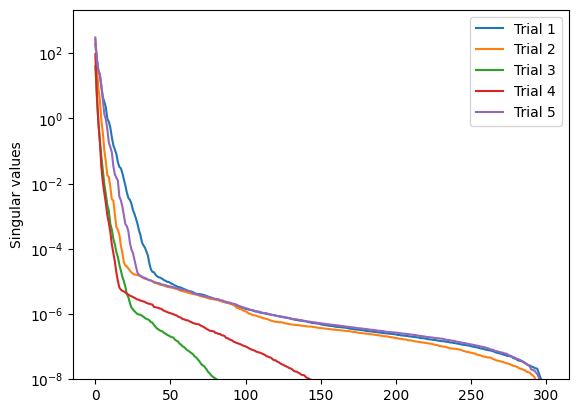

In [7]:
# Using Tanh activation function
plt.figure()
for ii in tqdm(range(5)):
    # Random parameters
    theta_init = np.random.randn(N)
    # Compute Jacobian
    J = jax.jacfwd(f)(theta_init, dims, xsamples, jax.nn.tanh)
    # Compute the singular values of the Jacobian
    s = np.linalg.svd(J, compute_uv=False)
    # Plot
    plt.plot(s, label=f"Trial {ii+1}")
plt.yscale("log")
plt.ylabel("Singular values")
plt.ylim(bottom=1e-8)
plt.legend()
plt.show()

100%|██████████| 5/5 [01:03<00:00, 12.74s/it]


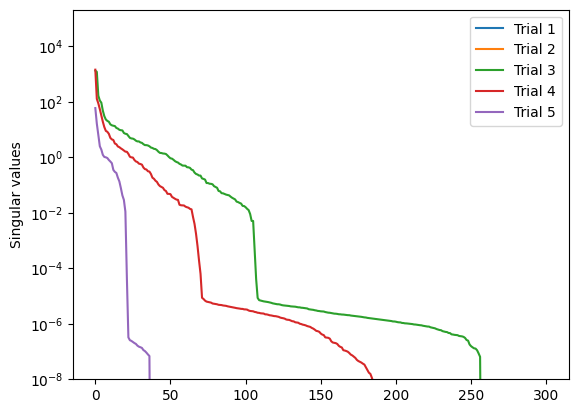

In [8]:
# Using ReLU activation function
plt.figure()
for ii in tqdm(range(5)):
    # Random parameters
    theta_init = np.random.randn(N)
    # Compute Jacobian
    J = jax.jacfwd(f)(theta_init, dims, xsamples, jax.nn.relu)
    # Compute the singular values of the Jacobian
    s = np.linalg.svd(J, compute_uv=False)
    # Plot
    plt.plot(s, label=f"Trial {ii+1}")
plt.yscale("log")
plt.ylabel("Singular values")
plt.ylim(bottom=1e-8)
plt.legend()
plt.show()

# Problem 3

Before proceeding to the solution of this problem, we will recreate the cost surface and model manifold obtained from the previous homework.
Note that we can only have a model with 2 parameters and 3 predictions.
Thus, we will reduce the number of parameters in the model and pretty much do what we have done in the previous homework.

In [9]:
# Download the data
data_file = Path("data/rat42.txt")
# Download the data file if it is not available
if not data_file.exists():
    link = f"https://raw.githubusercontent.com/TheoryOfPredictiveModeling/data/main/{data_file.name}"
    subprocess.run(["wget", link, "-O", data_file])

In [10]:
# Load the crop yield data
data = np.loadtxt(data_file)
gt, py = data.T
npreds = len(py)

print("Data:")
print("Growing time \t Pasture yield")
print(data)

Data:
Growing time 	 Pasture yield
[[ 9.    8.93]
 [14.   10.8 ]
 [21.   18.59]
 [28.   22.33]
 [42.   39.35]
 [57.   56.11]
 [63.   61.73]
 [70.   64.62]
 [79.   67.08]]


In [11]:
# Define functions that define the original model and residuals. These functions are
# used to fit the full model to the data and obtain the best fit parameters.
def y(theta, t=gt):
    """The full model to use in this problem. The transformation from theta to phi is
    done here.
    """
    phi = np.exp(theta)
    return phi[0] / (1 + np.exp(phi[1] - t * phi[2]))


def residuals(theta, t=gt, data=py):
    """The residual function, which returns the difference between the data and the
    predicted values.
    """
    preds = y(theta, t)
    return data - preds

In [12]:
# Use LM algorithm to solve the nonlinear least-squares problem and obtain the best
# fit parameters.
res = opt.least_squares(residuals, np.zeros(3), method="lm")
theta_star = res.x  # Extract the best fit theta
phi_star = np.exp(theta_star)  # Best fit phi

print("LM algorithm output:")
print(res)
print(f"Best fit parameters (theta): {theta_star}")
print(f"Best fit parameters (phi): {phi_star}")

LM algorithm output:
     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 3.820e-01 -6.311e-01  1.862e+00 -1.202e+00 -6.896e-01
                1.467e-01  1.183e+00  8.384e-02 -8.331e-01]
           x: [ 4.283e+00  9.624e-01 -2.698e+00]
        cost: 4.02826146690643
         jac: [[-8.548e+00  1.974e+01 -4.571e+00]
               [-1.143e+01  2.521e+01 -9.079e+00]
               ...
               [-6.454e+01  1.848e+01 -3.328e+01]
               [-6.791e+01  1.116e+01 -2.269e+01]]
        grad: [-1.442e-08 -3.212e-05  4.405e-05]
  optimality: 4.40532773371118e-05
 active_mask: [0 0 0]
        nfev: 59
        njev: None
Best fit parameters (theta): [ 4.28306554  0.96244004 -2.69771574]
Best fit parameters (phi): [7.24622359e+01 2.61807689e+00 6.73592034e-02]


<ipython-input-11-dcf8bde9b736>:8: RuntimeWarning: overflow encountered in exp
  return phi[0] / (1 + np.exp(phi[1] - t * phi[2]))


In [13]:
# Reduced the number of parameters by setting phi 1 to its best fit value
theta1 = theta_star[0]
phi1 = phi_star[0]


def y_reduced(theta, t=gt):
    """Reduced model by holding phi_1 at its best fit value."""
    params = np.array([theta1, *theta])
    return y(params, t)


def cost_reduced(theta, t=gt, data=py):
    """Least-squares cost function using the reduced model."""
    preds = y_reduced(theta, t)
    res = data - preds
    return np.linalg.norm(res) ** 2 / 2

In [14]:
# Generate the data to plot the cost surface and the model manifold
# Define the values of parameters to generate the parameter grid
th2_fine = np.linspace(-10, 10, 201)
th3_fine = np.linspace(-10, 10, 201)

TH2, TH3 = np.meshgrid(th2_fine, th3_fine)
shape = TH2.shape

# Iterate over combination of phi2 and phi3 and compute the predictions and cost
Preds = np.empty((*shape, len(gt)))
Cost = np.empty(shape)
for ii in range(shape[0]):
    for jj in range(shape[1]):
        params = np.array([TH2[ii, jj], TH3[ii, jj]])
        Preds[ii, jj] = y_reduced(params)
        Cost[ii, jj] = cost_reduced(params)

<ipython-input-11-dcf8bde9b736>:8: RuntimeWarning: overflow encountered in exp
  return phi[0] / (1 + np.exp(phi[1] - t * phi[2]))


In [15]:
# # Plot the cost surface
# plt.figure()

# locator = mpl.ticker.LogLocator()
# levels = np.logspace(1, 4, 13)

# plt.contourf(TH2, TH3, Cost, locator=locator, levels=levels)
# plt.plot(*res.x[1:], ".k", label="best fit")

# clb = plt.colorbar()
# clb.set_label("cost")

# plt.xlabel(r"$\theta_2 = \log(\phi_2)$")
# plt.ylabel(r"$\theta_3 = \log(\phi_3)$")
# plt.legend()
# plt.show()

In [16]:
# Choose 3 random time points to plot the model manifold
idx_data = np.sort(np.random.choice(range(len(gt)), 3, replace=True))
print(f"Time index: {idx_data}")

Time index: [0 3 7]


In [17]:
# # Project the model manifold
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# # Plot model manifold
# ax.plot_surface(*(Preds[:, :, idx_data]).T, shade=True, antialiased=False, color="pink")
# # Plot the data
# ax.plot(*(py[idx_data].reshape((-1, 1))), "r.", zorder=100)

# ax.set_xlabel(f"$y(t_{idx_data[0]})$")
# ax.set_ylabel(f"$y(t_{idx_data[1]})$")
# ax.set_zlabel(f"$y(t_{idx_data[2]})$")

# ax.view_init(30, 0)

# plt.tight_layout()
# plt.show()

## Part a

In this part, we will do the calculation to the reduced model with only 2 parameters.
The cost function is defined as
\begin{equation*}
    C(\theta) = \frac{1}{2} \sum_m \left( d_m - y_m(\theta) \right)^2,
\end{equation*}
where $d_m$ is the $m^{th}$ data point and $y_m(\theta) = y(t_m; \theta)$ is the prediction in the $m^{th}$ time point.
The elements of the gradient vector of the cost in parameter space is
\begin{equation*}
    (\partial_i C) = \frac{\partial C}{\partial \theta_i}
    = - \sum_m \left( (d_m - y_m(\theta)) \frac{\partial y_m}{\partial \theta_i} \right),
    i = 2, 3
\end{equation*}
For this problem, the gradient of the cost function can be calculated analytically (with the help of Mathematica):
\begin{align*}
    \frac{\partial y_m}{\partial \theta_2} &=
        - \frac{\phi_1 \phi_2}{2 (1 + \cosh(\phi2 - \phi_3 t)}, \\
    \frac{\partial y_m}{\partial \theta_3} &=
        \frac{\phi_1 \phi_3 t}{2 + 2\cosh(\phi2 - \phi3 t)},
\end{align*}
where $phi_i = e^{\theta_i}$, as mentioned in the previous homework.

The natural gradient of the cost is given by
\begin{equation*}
    \nabla C = G^{-1} (\partial C)',
\end{equation*}
where the metric $G$ equals to the Fisher Information matrix (FIM).

In [18]:
# Define functions to calculate the gradients of the cost function
def dydth2(theta):
    """Derivative of the reduced model with respect to theta2."""
    phi2, phi3 = np.exp(theta)
    numerator = -phi1 * phi2
    denominator = 2 * (1 + np.cosh(phi2 - phi3 * gt))
    return numerator / denominator


def dydth3(theta):
    """Derivative of the reduced model with respect to theta3."""
    phi2, phi3 = np.exp(theta)
    numerator = phi1 * phi3 * gt
    denominator = 2 + 2 * np.cosh(phi2 - phi3 * gt)
    return numerator / denominator


def grad_cost(theta):
    """Compute the gradient of the cost function in parameter space."""
    dC2 = np.sum((py - y_reduced(theta)) * dydth2(theta))
    dC3 = np.sum((py - y_reduced(theta)) * dydth3(theta))
    return -np.array([dC2, dC3])


def jacobian(theta):
    """Compute the jacobian matrix of the reduced model."""
    col1 = dydth2(theta)
    col2 = dydth3(theta)
    return np.row_stack((col1, col2)).T


def fim(theta):
    """Compute the FIM of the reduced model."""
    J = jacobian(theta)
    return J.T @ J


def natural_grad_cost(theta):
    """Compute the natural gradient of the cost function in parameter space."""
    I = fim(theta)
    grad_C = grad_cost(theta)
    return np.linalg.pinv(I) @ grad_C

For this problem, we will randomly sample points in parameter space and compute the gradient and the natural gradient at those points.

In [19]:
# This specifies how we define the parameter points. Options: random or grid
type = "grid"

if type == "random":
    # Get a random parameter points
    npoints = 50
    params_points = np.random.uniform(-9, 9, size=(npoints, 2))
elif type == "grid":
    temp1 = temp2 = np.arange(-9, 10, 2)
    T1, T2 = np.meshgrid(temp1, temp2)
    params_points = np.row_stack((T1.flatten(), T2.flatten())).T
    npoints = len(params_points)

# Map these points to data space
preds_points = np.array([y_reduced(pp) for pp in params_points])

<ipython-input-11-dcf8bde9b736>:8: RuntimeWarning: overflow encountered in exp
  return phi[0] / (1 + np.exp(phi[1] - t * phi[2]))


By looking at the cost surface, some of the points we pick might be located on the plateau.
Notice that the cost surface on the plateau is pretty much flat, thus the derivative of the cost would be zero.
This results in the singular jacobian.
We check if the points we have are on the plateau by observing the singular values of the jacobian; if the singular values have zero element, then we can conclude that the point is located on the plateau.

In [20]:
# Compute the jacobian for every single points
Jacobians = np.empty((npoints, npreds, 2))
for ii, pp in enumerate(params_points):
    Jacobians[ii] = jacobian(pp)

# print("Singular values of the jacobian:")
# for jj in Jacobians:
#     s = np.linalg.svd(jj, compute_uv=False)
#     print(f"{s[0]:0.6e} \t {s[1]:0.6e}")

<ipython-input-18-251448849a77>:6: RuntimeWarning: overflow encountered in cosh
  denominator = 2 * (1 + np.cosh(phi2 - phi3 * gt))
<ipython-input-18-251448849a77>:14: RuntimeWarning: overflow encountered in cosh
  denominator = 2 + 2 * np.cosh(phi2 - phi3 * gt)


After computing the gradient and natural gradient of the cost function in parameter space, we need to transform these quantities to the data space.
The transformation is done by using the jacobian of the model:
\begin{align*}
    (\partial C)_y &= J (\partial C)_{\theta} \\
    (\nabla C)_y &= J (\nabla C)_{\theta},
\end{align*}
where $(\_)_y$ and $(\_)_{\theta}$ denote the gradient/natural gradient in data space and parameter space ,respectively.

In [21]:
# Compute the gradient of the cost
# In parameter space
grad_C_params = np.array([grad_cost(pp) for pp in params_points])
# In prediction space
grad_C_preds = np.array(
    [jacobian(pp) @ grad_C_params[ii] for ii, pp in enumerate(params_points)]
)
# Compute the natural gradient of the cost
# In parameter space
ngrad_C_params = np.array([natural_grad_cost(pp) for pp in params_points])
# In prediction space
ngrad_C_preds = np.array(
    [jacobian(pp) @ ngrad_C_params[ii] for ii, pp in enumerate(params_points)]
)

# print("Gradient of the cost in parameter space:")
# print("theta_2 \t\t theta_3 \t dC/dtheta_2 \t dC/dtheta_3")
# print(np.hstack((params_points, grad_C_params)))

<ipython-input-11-dcf8bde9b736>:8: RuntimeWarning: overflow encountered in exp
  return phi[0] / (1 + np.exp(phi[1] - t * phi[2]))
<ipython-input-18-251448849a77>:6: RuntimeWarning: overflow encountered in cosh
  denominator = 2 * (1 + np.cosh(phi2 - phi3 * gt))
<ipython-input-18-251448849a77>:14: RuntimeWarning: overflow encountered in cosh
  denominator = 2 + 2 * np.cosh(phi2 - phi3 * gt)


In [22]:
# Define the scaling factor used in plotting the gradients
factor = 15
# Gradient in parameter space
scale_grad_C_params = np.linalg.norm(grad_C_params, axis=1) * factor
# Natural gradient in parameter space
scale_ngrad_C_params = np.linalg.norm(ngrad_C_params, axis=1) * factor
# Gradient in data space
scale_grad_C_preds = np.linalg.norm(grad_C_preds, axis=1) * factor
# Natural gradient in data space
scale_ngrad_C_preds = np.linalg.norm(ngrad_C_preds, axis=1) * factor

/usr/local/lib/python3.10/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.10/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


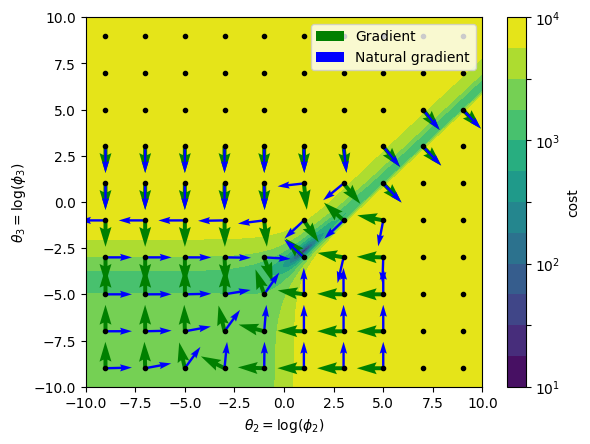

In [23]:
# Plot the gradients on the cost surface
plt.figure()

locator = mpl.ticker.LogLocator()
levels = np.logspace(1, 4, 13)

im = plt.contourf(TH2, TH3, Cost, locator=locator, levels=levels)
plt.plot(*params_points.T, "k.")

plt.quiver(
    *(params_points.T),
    *(-grad_C_params.T),
    color="green",
    width=0.01,
    scale=scale_grad_C_params,
    label="Gradient"
)
plt.quiver(
    *(params_points.T),
    *(-ngrad_C_params.T),
    color="blue",
    scale=scale_ngrad_C_params,
    label="Natural gradient"
)

clb = plt.colorbar(im)
clb.set_label("cost")

plt.xlabel(r"$\theta_2 = \log(\phi_2)$")
plt.ylabel(r"$\theta_3 = \log(\phi_3)$")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/art3d.py:1196: RuntimeWarning: divide by zero encountered in divide
  shade = ((normals / np.linalg.norm(normals, axis=1, keepdims=True))
<ipython-input-24-39b03639be87>:12: RuntimeWarning: divide by zero encountered in divide
  *((-grad_C_preds[:, idx_data] / scale_grad_C_preds.reshape((-1, 1)) * 500).T),
<ipython-input-24-39b03639be87>:12: RuntimeWarning: invalid value encountered in divide
  *((-grad_C_preds[:, idx_data] / scale_grad_C_preds.reshape((-1, 1)) * 500).T),
<ipython-input-24-39b03639be87>:19: RuntimeWarning: invalid value encountered in divide
  *((-ngrad_C_preds[:, idx_data] / scale_ngrad_C_preds.reshape((-1, 1)) * 500).T),


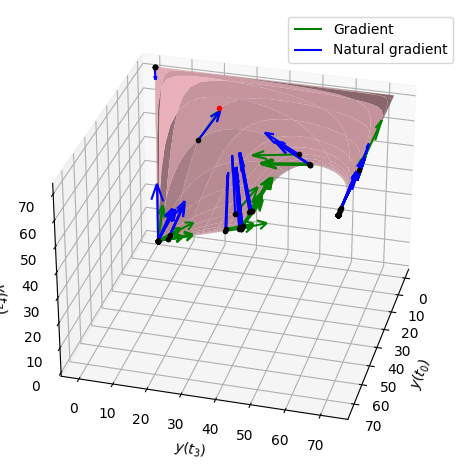

In [24]:
# Project the model manifold
ax = plt.figure().add_subplot(projection="3d")

# Plot model manifold
ax.plot_surface(*(Preds[:, :, idx_data]).T, shade=True, color="pink")
# Plot the data
ax.plot(*(py[idx_data].reshape((-1, 1))), "r.", zorder=100)

ax.plot(*(preds_points[:, idx_data].T), "k.", zorder=50)
ax.quiver(
    *(preds_points[:, idx_data].T),
    *((-grad_C_preds[:, idx_data] / scale_grad_C_preds.reshape((-1, 1)) * 500).T),
    color="green",
    zorder=50,
    label="Gradient",
)
ax.quiver(
    *(preds_points[:, idx_data].T),
    *((-ngrad_C_preds[:, idx_data] / scale_ngrad_C_preds.reshape((-1, 1)) * 500).T),
    color="blue",
    zorder=50,
    label="Natural gradient",
)

ax.set_xlabel(f"$y(t_{idx_data[0]})$")
ax.set_ylabel(f"$y(t_{idx_data[1]})$")
ax.set_zlabel(f"$y(t_{idx_data[2]})$")

ax.view_init(30, 15)

plt.legend()
plt.tight_layout()
plt.show()

From the figure of the natural gradient in parameter space above, interestingly some of the natural gradient directions are not pointed to the data.
There are several possible explanation about this:
1. We are plotting a 3-dimensional object, and the plot above doesn't do justice to show the model manifold.
2. The natural gradient must lie on a tangent plane of the manifold at the point it is evaluated.
Due to the structure of the manifold, the span of the tangent plane might not be far from crossing the data, or the best prediction.

## Part b

To find the points in parameter space where the gradient and natural gradient are nearly orthogonal, we will evaluate the angle between these vectors.
Using the cross-product, the angle is calculated by
\begin{equation*}
    \cos(\theta) = \frac{(\partial C) \cdot (\nabla C)}{\Vert \partial C \Vert \Vert \nabla C \Vert}
\end{equation*}

In [25]:
print("theta_2 \t theta_3 \t Angle \t Condition number")
print("-" * 60)
for pp, grad, ngrad in zip(params_points, grad_C_params, ngrad_C_params):
    norm_grad = np.linalg.norm(grad)
    norm_ngrad = np.linalg.norm(ngrad)

    if norm_grad:
        # Only do the calculation when the magnitude of the gradient is non-zero

        grad /= norm_grad  # Normalize the gradient
        ngrad /= norm_ngrad  # Normalie the natural gradient

        # Calculate angle in degree. We also force the dot product between the gradient
        # and the natural gradient to be values between -1 and 1 (using np.clip).
        angle = np.degrees(np.arccos(np.clip(grad @ ngrad, -1, 1)))

        # Compute the condition number of the FIM
        I = fim(pp)
        cond = np.linalg.cond(I)
        print(f"{pp[0]:0.6f} \t {pp[1]:0.6f} \t {angle:0.2f} \t {cond:0.4e}")

theta_2 	 theta_3 	 Angle 	 Condition number
------------------------------------------------------------
-9.000000 	 -9.000000 	 88.78 	 9.7614e+03
-7.000000 	 -9.000000 	 81.12 	 1.8488e+02
-5.000000 	 -9.000000 	 48.33 	 1.4360e+01
-3.000000 	 -9.000000 	 68.82 	 2.8119e+02
-1.000000 	 -9.000000 	 88.66 	 1.5021e+04
1.000000 	 -9.000000 	 89.86 	 8.1962e+05
3.000000 	 -9.000000 	 89.98 	 4.4748e+07
5.000000 	 -9.000000 	 90.00 	 2.4432e+09
-9.000000 	 -7.000000 	 89.83 	 5.3189e+05
-7.000000 	 -7.000000 	 88.76 	 9.7481e+03
-5.000000 	 -7.000000 	 80.98 	 1.8467e+02
-3.000000 	 -7.000000 	 48.98 	 1.4365e+01
-1.000000 	 -7.000000 	 80.08 	 2.8119e+02
1.000000 	 -7.000000 	 88.96 	 1.5010e+04
3.000000 	 -7.000000 	 89.85 	 8.1921e+05
5.000000 	 -7.000000 	 89.98 	 4.4727e+07
-9.000000 	 -5.000000 	 89.97 	 2.6953e+07
-7.000000 	 -5.000000 	 89.76 	 4.9377e+05
-5.000000 	 -5.000000 	 88.27 	 9.0637e+03
-3.000000 	 -5.000000 	 78.31 	 1.7383e+02
-1.000000 	 -5.000000 	 53.89 	 1.4602e+

<ipython-input-18-251448849a77>:6: RuntimeWarning: overflow encountered in cosh
  denominator = 2 * (1 + np.cosh(phi2 - phi3 * gt))
<ipython-input-18-251448849a77>:14: RuntimeWarning: overflow encountered in cosh
  denominator = 2 + 2 * np.cosh(phi2 - phi3 * gt)


As previously mentioned, there are points that have zero gradients.
For this part of the problem, we specifically excluded those points.
Besides that, note that at some points the gradient and natural gradient are parallel to each other.
In principle, the FIM of these points would be singular, and thus the condition number would be infinite (or large numbers numerically), which is the behavior we see above.

For the points with non-singular FIM, notice that the condition number increases as the angle between the gradient and natural gradient approaches $90^\circ$.

# Problem 4

## Part a

In [26]:
# Need to have stop > 10, so 10 gets included .
t = np.arange(0, 10.1, 0.5)
theta_true = [2, 3]


def f(theta, t):
    # Evaluate the function at each of the time points
    N = len(theta)
    M = len(t)

    # Store a vector of function evals
    fvals = np.zeros(M)
    for i in range(M):
        s = 0
        for j in range(N):
            s += np.exp(-theta[j] * t[i])
        fvals[i] = s / N

    return fvals


def residuals(theta):
    return f(theta, t) - f(theta_true, t)


def Cost(theta):
    return np.linalg.norm(residuals(theta))

## Part b

In [27]:
npoints = 200
theta = np.linspace(1, 5, npoints)
Theta0, Theta1 = np.meshgrid(theta, theta)
C = np.zeros_like(Theta0)

for i in range(npoints):
    for j in range(npoints):
        C[i, j] = Cost([Theta0[i, j], Theta1[i, j]])

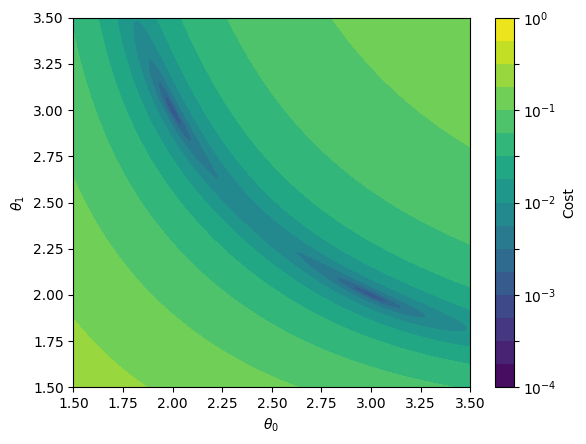

In [28]:
locator = mpl.ticker.LogLocator()
levels = np.logspace(-4, 0, 17)


def plot_cost_contours():
    plt.figure()
    plt.contourf(Theta0, Theta1, C, locator=locator, levels=levels)
    plt.colorbar(label="Cost")
    plt.xlabel(r"$\theta_0$ ")
    plt.ylabel(r"$\theta_1$ ")


plot_cost_contours()
plt.xlim(1.5, 3.5)
plt.ylim(1.5, 3.5)
plt.show()

## Part c

In [29]:
# Cost function where the two parameters are equal
def Cost_equal_theta(x):
    theta = np.repeat(x, 2)
    return Cost(theta)

# Optimize
results = opt.minimize(Cost_equal_theta, 2.5)
theta_equal = np.repeat(results.x, 2)
print(results)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0066138673499342784
        x: [ 2.416e+00]
      nit: 4
      jac: [ 4.540e-08]
 hess_inv: [[ 2.080e-01]]
     nfev: 14
     njev: 7


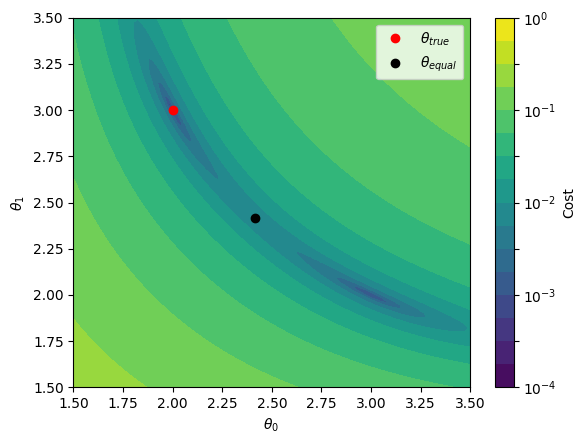

In [30]:
# Plot the optimal parameters on the cost surface
plot_cost_contours()
plt.plot(*theta_true, "ro", label=r"$\theta_{true}$")
plt.plot(*theta_equal, "ko", label=r"$\theta_{equal}$")
plt.xlim(1.5, 3.5)
plt.ylim(1.5, 3.5)
plt.legend()
plt.show()

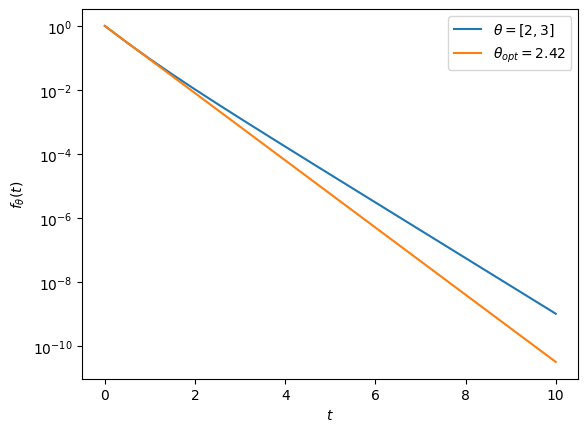

In [31]:
# Plot the model output
plt.figure()
plt.plot(t, f(theta_true, t), label=f"$\\theta=[{theta_true[0]}, {theta_true[1]}]$")
plt.plot(t, f(theta_equal, t), label=f"$\\theta_{{opt}}={theta_equal[0]:0.2f}$")
plt.yscale("log")
plt.xlabel(r"$t$")
plt.ylabel(r"$f_\theta (t)$")
plt.legend()
plt.show()

## Part d

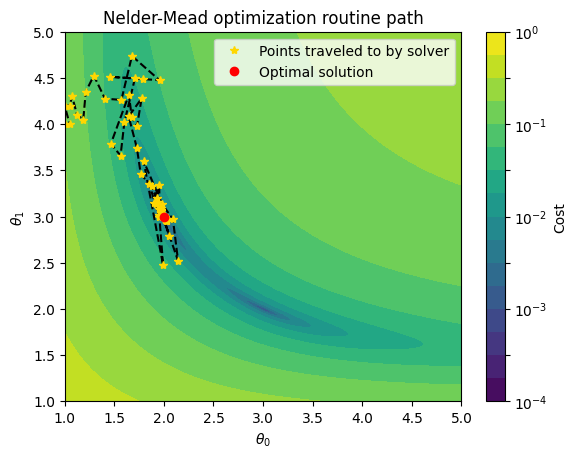

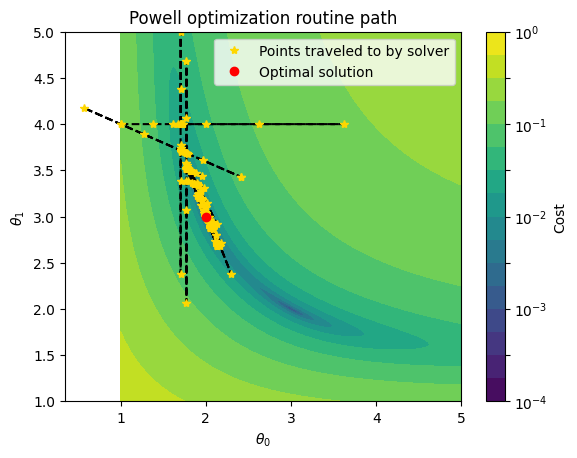

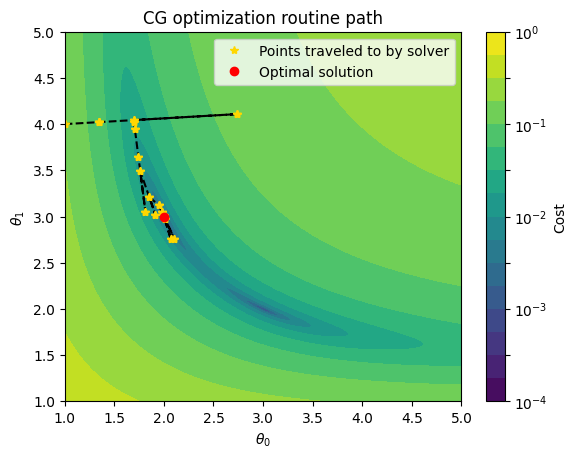

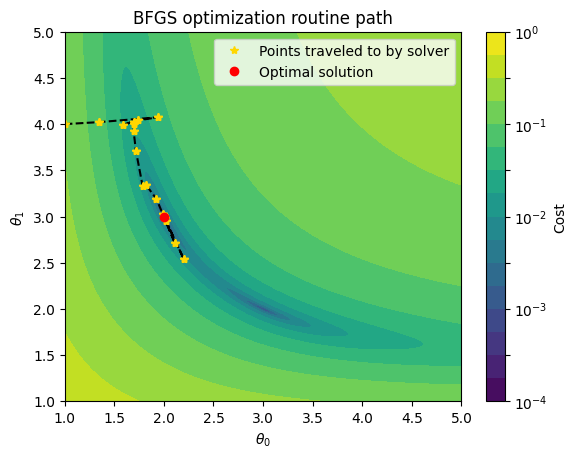

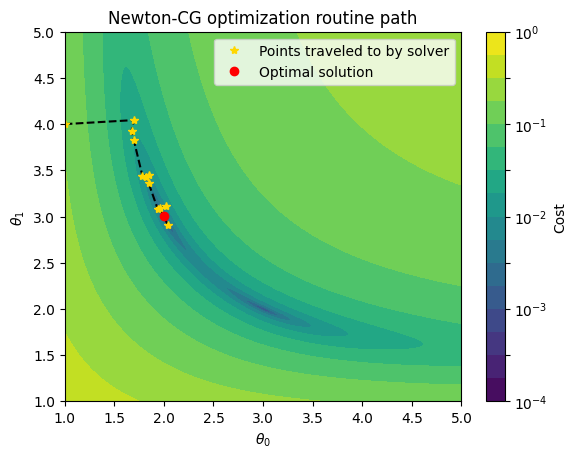

In [32]:
theta_0 = [1, 4]
methods_list = ["Nelder-Mead", "Powell", "CG", "BFGS", "Newton-CG"]

for method in methods_list:
    if method == "Newton-CG":
        kwargs = {"jac": nd.Gradient(Cost)}
    else:
        kwargs = {}
    params = []

    def CostWrapper(theta):
        params.append(copy.deepcopy(theta))
        return Cost(theta)

    results = opt.minimize(CostWrapper, theta_0, method=method, **kwargs)
    params = np.array(params)

    # Plot the optimal parameters on the cost surface
    plot_cost_contours()
    plt.title(f"{method} optimization routine path")
    plt.plot(*(params.T), "k--")
    plt.plot(*(params.T), "*", color="gold", label="Points traveled to by solver")
    plt.plot(*results.x, "ro", label=f"Optimal solution")
    plt.legend()
    plt.show()

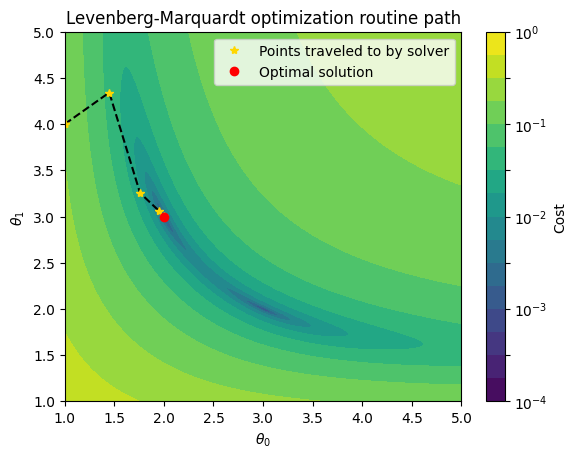

In [33]:
# Levenberg-Marquardt
params = []


def ResidualWrapper(theta):
    params.append(copy.deepcopy(theta))
    return residuals(theta)


results = opt.least_squares(
    ResidualWrapper, theta_0, method="lm", jac=nd.Jacobian(residuals)
)
params = np.array(params)

# Plot the optimal parameters on the cost surface
plot_cost_contours()
plt.title("Levenberg-Marquardt optimization routine path")
plt.plot(*(params.T), "k--")
plt.plot(*(params.T), "*", color="gold", label="Points traveled to by solver")
plt.plot(*results.x, "ro", label="Optimal solution")
plt.legend()
plt.show()

# Problem 5

For this problem, we want to fit the data to a model of the form
\begin{equation*}
    y(t; \theta) = \theta_1 + \theta_2 e^{\theta_4 t} + \theta_e e^{-\theta_5 t}.
\end{equation*}

In [34]:
# Download the data
data_file = Path("data/mgh17.txt")
# Download the data file if it is not available
if not data_file.exists():
    link = f"https://raw.githubusercontent.com/TheoryOfPredictiveModeling/data/main/{data_file.name}"
    subprocess.run(["wget", link, "-O", data_file])

start_file = Path("data/mgh17_startingpoints.txt")
# Download the data file if it is not available
if not start_file.exists():
    link = f"https://raw.githubusercontent.com/TheoryOfPredictiveModeling/data/main/{start_file.name}"
    subprocess.run(["wget", link, "-O", start_file])

In [35]:
# Load the data needed for this problem
temp = np.loadtxt(data_file)
time_points, data = temp.T
npreds = len(data)

# print("Data:")
# print(temp)

In [36]:
# Load the starting points
start_points = np.loadtxt(start_file).T
nstart = len(start_points)

print("Starting points:")
print(start_points)

Starting points:
[[ 5.00000000e+01  1.50000000e+02 -1.00000000e+02  1.00000000e+00
   2.00000000e+00]
 [ 5.00000000e-01  1.50000000e+00 -1.00000000e+00  1.00000000e-02
   2.00000000e-02]
 [ 3.75410052e-01  1.93584691e+00 -1.46468714e+00  1.28675346e-02
   2.21226997e-02]]


## Part a

In [37]:
def model(theta):
    """Model we use to fit the data."""
    th1, th2, th3, th4, th5 = theta
    return th1 + th2 * np.exp(-th4 * time_points) + th3 * np.exp(-th5 * time_points)


def residuals(theta):
    """Compute the residuals of the model."""
    preds = model(theta)
    return data - preds


def cost(theta):
    """Compute the cost value of the model."""
    res = residuals(theta)
    return np.sum(res**2) / 2


def jacobian(theta):
    """Compute the jacobian matrix of the model."""
    th1, th2, th3, th4, th5 = theta
    col1 = np.ones(npreds)
    col2 = np.exp(-th4 * time_points)
    col3 = np.exp(-th5 * time_points)
    col4 = -th2 * time_points * np.exp(-th4 * time_points)
    col5 = -th3 * time_points * np.exp(-th5 * time_points)

    return -np.row_stack((col1, col2, col3, col4, col5)).T


def fim(theta):
    """Compute the FIM of the model."""
    Jac = jacobian(theta)
    return Jac.T @ Jac

The condition number of the FIM is calculated by taking the ratio between the largest and smallest singular values of the FIM (or the eigenvalues since the FIM is symmetric).
Since the FIM is calculated by taking $J'J$, where $J$ is the jacobian matrix, the eigenvalues of the FIM equals to the square of the singular values of the jacobian.
For this part of the problem, we will calculate the condition number of the FIM by taking the squared ratio between the largest and the smallest singular values of the jacobian.

If we apply `np.linalg.cond` to the FIM, instead, the condition number would be the same, except for the first starting point.
This actually shows that the first starting point is bad.

In [38]:
# Compute the condition number of the FIM for every starting point
for point in start_points:
    Jac = jacobian(point)
    I = fim(point)

    s = np.linalg.svd(Jac, compute_uv=False)
    kappa = (s[0] / s[-1]) ** 2
    print(f"Starting point: {point}")
    print(f"\t Condition number: {kappa:0.6e}\n")

Starting point: [  50.  150. -100.    1.    2.]
	 Condition number: 1.927965e+30

Starting point: [ 0.5   1.5  -1.    0.01  0.02]
	 Condition number: 1.119294e+09

Starting point: [ 0.37541005  1.93584691 -1.46468714  0.01286753  0.0221227 ]
	 Condition number: 2.385581e+09



## Part b

We listed all optimization algorithm in [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html) below.
We will try to use as many methods as we can for this part of the problem.

In [39]:
minimize_methods = [
    "Nelder-Mead",
    "Powell",
    "CG",
    "BFGS",
    "Newton-CG",
    "L-BFGS-B",
    "TNC",
    "COBYLA",
    "SLSQP",
    "trust-constr",
    "dogleg",
    "trust-ncg",
    "trust-krylov",
    # "trust-exact",  # This method still won't work for me
]
global_method = ["basinhopping"]
least_squares_method = ["trf", "dogbox", "lm"]

methods = minimize_methods + global_method + least_squares_method

Some of the methods above require the users to define the jacobian and hessian of the cost function.
For this model, we can actually calculate these quantities analytically (maybe with the help of Mathematica).
We define these quantities below.

In [40]:
def jac_cost(theta):
    """Compute the derivative of the cost function."""
    th1, th2, th3, th4, th5 = theta
    res = residuals(theta)

    df1 = np.ones(npreds)
    df2 = np.exp(-th4 * time_points)
    df3 = np.exp(-th5 * time_points)
    df4 = -th2 * time_points * np.exp(-th4 * time_points)
    df5 = -th3 * time_points * np.exp(-th5 * time_points)

    dc1 = np.sum(res * df1)
    dc2 = np.sum(res * df2)
    dc3 = np.sum(res * df3)
    dc4 = np.sum(res * df4)
    dc5 = np.sum(res * df5)

    return -np.array([dc1, dc2, dc3, dc4, dc5])


def hess_cost(theta):
    """Compute the hessian of th cost function."""
    th1, th2, th3, th4, th5 = theta
    res = residuals(theta)
    I = fim(theta)

    D2 = np.zeros((5, 5, npreds))
    D2[1, 3] = D2[3, 1] = res * (-time_points * np.exp(-th4 * time_points))
    D2[2, 4] = D2[4, 2] = res * (-time_points * np.exp(-th5 * time_points))
    D2[3, 3] = res * th2 * time_points**2 * np.exp(-th4 * time_points)
    D2[4, 4] = res * th3 * time_points**2 * np.exp(-th5 * time_points)

    return I - np.sum(D2, axis=2)

In [41]:
warnings.filterwarnings("ignore")  # Suppress all warnings
Optimization = {}

for ii, point in enumerate(start_points):
    print(f"Starting point: {point}")
    temp = {}
    for method in methods:
        print(f"\t Method: {method}")
        start_time = time.perf_counter()
        if method in minimize_methods:
            opt_res = opt.minimize(
                cost,
                point,
                method=method,
                jac=jac_cost,
                hess=hess_cost,
                options={"maxiter": 100000},
            )
            opt_cost = opt_res.fun
        elif method in global_method:
            opt_res = opt.basinhopping(cost, point)
            opt_cost = opt_res.fun
        elif method in least_squares_method:
            opt_res = opt.least_squares(
                residuals, point, method=method, jac="3-point", max_nfev=100000
            )
            opt_cost = opt_res.cost
        end_time = time.perf_counter()
        evaluation_time = end_time - start_time

        opt_params = opt_res.x
        opt_message = opt_res.message

        Jac = jacobian(opt_params)
        s = np.linalg.svd(Jac, compute_uv=False)
        kappa = (s[0] / s[-1]) ** 2

        temp.update(
            {
                method: {
                    "params": opt_params,
                    "cost": opt_cost,
                    "jacobian": Jac,
                    "kappa": kappa,
                    "message": opt_message,
                }
            }
        )
        # print(f"\t\t Optimum parameter: {opt_params}")
        print(f"\t\t Optimum cost: {opt_cost}")
        print(f"\t\t Termination message: {opt_message}")
        print(f"\t\t Evaluation time: {evaluation_time:0.3e} s \n")

    Optimization.update({f"Starting_point_{ii}": temp})
    print("-" * 120)

Starting point: [  50.  150. -100.    1.    2.]
	 Method: Nelder-Mead
		 Optimum cost: 0.5526936559876524
		 Termination message: Optimization terminated successfully.
		 Evaluation time: 2.568e-02 s 

	 Method: Powell
		 Optimum cost: 0.5109112965998474
		 Termination message: Optimization terminated successfully.
		 Evaluation time: 1.355e-02 s 

	 Method: CG
		 Optimum cost: 0.5141422844516874
		 Termination message: Desired error not necessarily achieved due to precision loss.
		 Evaluation time: 7.427e-03 s 

	 Method: BFGS
		 Optimum cost: 0.5530181824381568
		 Termination message: Optimization terminated successfully.
		 Evaluation time: 2.741e-03 s 

	 Method: Newton-CG
		 Optimum cost: 0.5112160162816065
		 Termination message: Optimization terminated successfully.
		 Evaluation time: 1.230e-02 s 

	 Method: L-BFGS-B
		 Optimum cost: 0.5112160162791319
		 Termination message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
		 Evaluation time: 9.250e-03 s 

	 Method: TNC
		 Op

From the results above, we think that the best fit point is close to the optimization result using LM algorithm with the last starting point.
Thus, one criterion to decide if the algorithm we use succeeded is to compare the optimized cost value obtained from that algorithm to the best cost we know (e.g. from the result using LM algorithm) with some small tolerance.
As an example, we know that the best cost from the LM algorithm is $\sim 10^{-5}$.
Thus, we can set the tolerance to be $5 \times 10^{-6}$ and see which algoritm and which starting point give us a cost value that is closed enough to the best cost.

In [42]:
# For aesthetic purpose
short_list = [
    "Powell",
    "CG",
    "BFGS",
    "TNC",
    "COBYLA",
    "SLSQP",
    "dogleg",
    "trf",
    "dogbox",
    "lm",
]

In [43]:
# Using cost criterion
cost_min = Optimization["Starting_point_2"]["lm"]["cost"]  # Best cost
cost_tol = 5e-6  # Cost tolerance

print("Algorithm \t starting point 1 \t starting point 2 \t starting point 3")
print("-" * 88)

for method in methods:
    status = []
    for ii in range(nstart):
        # Extract the cost value
        opt_cost = Optimization[f"Starting_point_{ii}"][method]["cost"]

        # Compare the cost value
        cost_diff = np.abs(opt_cost - cost_min)
        if cost_diff < cost_tol:
            status.append("succeeded")
        else:
            status.append("failed")

    if method in short_list:
        extra_tab = "\t"
    else:
        extra_tab = ""

    print(f"{method} \t{extra_tab} {status[0]} \t\t {status[1]} \t\t {status[2]}")

Algorithm 	 starting point 1 	 starting point 2 	 starting point 3
----------------------------------------------------------------------------------------
Nelder-Mead 	 failed 		 succeeded 		 succeeded
Powell 		 failed 		 failed 		 succeeded
CG 		 failed 		 succeeded 		 succeeded
BFGS 		 failed 		 succeeded 		 succeeded
Newton-CG 	 failed 		 failed 		 succeeded
L-BFGS-B 	 failed 		 failed 		 succeeded
TNC 		 failed 		 failed 		 succeeded
COBYLA 		 failed 		 failed 		 failed
SLSQP 		 failed 		 succeeded 		 succeeded
trust-constr 	 failed 		 failed 		 succeeded
dogleg 		 failed 		 failed 		 succeeded
trust-ncg 	 failed 		 succeeded 		 succeeded
trust-krylov 	 failed 		 failed 		 succeeded
basinhopping 	 failed 		 succeeded 		 failed
trf 		 succeeded 		 succeeded 		 succeeded
dogbox 		 failed 		 succeeded 		 succeeded
lm 		 succeeded 		 succeeded 		 succeeded


A more sophisticated criterion looks at the angle between the residual vector in data space and the tangent plane of the model manifold.
Since we are using the $\ell_2$-norm cost function, the projection theorem often applies.
That is, the residual vector should be perpendicular to the tangent plane of the model manifold at the best fit point.
In practice, however, we will need to have some tolerance.

As a word of warning, this criterion doesn't always work, as there might be multiple local minima on the cost surface.
In this case, there will be multiple points on the model manifold that are perpendicular to the residual vector.
Another failing case is when the best fit point is located on the boundary of the model manifold.

In [44]:
# Using angle criterion
atol = 1  # Angle tolerance in degree

print("Algorithm \t starting point 1 \t starting point 2 \t starting point 3")
print("-" * 88)

for method in methods:
    status = []
    for ii in range(nstart):
        # Extract the values we need
        temp_dict = Optimization[f"Starting_point_{ii}"][method]
        Jac = temp_dict["jacobian"]  # Jacobian matrix
        params = temp_dict["params"]  # Optimal parameter
        res = residuals(params)  # Residual vector

        # Normalize the vectors
        Jac /= np.linalg.norm(Jac, axis=0)
        res /= np.linalg.norm(res)

        # Compute the angle
        angle = np.degrees(np.arccos(Jac.T @ res))
        angle_diff = np.abs(angle - 90)

        # Compare the cost value
        if np.all(angle_diff < atol):
            status.append("succeeded")
        else:
            status.append("failed")

    if method in short_list:
        extra_tab = "\t"
    else:
        extra_tab = ""

    print(f"{method} \t{extra_tab} {status[0]} \t\t {status[1]} \t\t {status[2]}")

Algorithm 	 starting point 1 	 starting point 2 	 starting point 3
----------------------------------------------------------------------------------------
Nelder-Mead 	 failed 		 succeeded 		 succeeded
Powell 		 succeeded 		 succeeded 		 succeeded
CG 		 failed 		 succeeded 		 succeeded
BFGS 		 failed 		 succeeded 		 succeeded
Newton-CG 	 succeeded 		 failed 		 succeeded
L-BFGS-B 	 succeeded 		 succeeded 		 succeeded
TNC 		 failed 		 succeeded 		 succeeded
COBYLA 		 succeeded 		 failed 		 failed
SLSQP 		 succeeded 		 succeeded 		 succeeded
trust-constr 	 succeeded 		 succeeded 		 succeeded
dogleg 		 failed 		 failed 		 succeeded
trust-ncg 	 succeeded 		 succeeded 		 succeeded
trust-krylov 	 succeeded 		 succeeded 		 succeeded
basinhopping 	 failed 		 succeeded 		 failed
trf 		 succeeded 		 succeeded 		 succeeded
dogbox 		 failed 		 succeeded 		 succeeded
lm 		 succeeded 		 succeeded 		 succeeded


## Part c

In [45]:
for ii, point_name in enumerate(Optimization):
    print(f"Starting point {ii + 1}: {start_points[ii]}")
    temp_point = Optimization[point_name]
    for method in temp_point:
        temp_method = temp_point[method]
        opt_cost = temp_method["cost"]

        if opt_cost > cost_min + cost_tol:
            kappa = temp_method["kappa"]
            if method in ["CG", "BFGS", "TNC"]:
                extra_tab = "\t"
            else:
                extra_tab = ""

            print(f"\t {method}: \t{extra_tab} Condition number {kappa}")
    print("-" * 80)

Starting point 1: [  50.  150. -100.    1.    2.]
	 Nelder-Mead: 	 Condition number 2.7919294453401055e+37
	 Powell: 	 Condition number 4.336922375007884e+17
	 CG: 		 Condition number 2.0874539559555955e+23
	 BFGS: 		 Condition number inf
	 Newton-CG: 	 Condition number 1.6985571934197355e+23
	 L-BFGS-B: 	 Condition number 1.6988024553997897e+23
	 TNC: 		 Condition number 2.0306260526950204e+27
	 COBYLA: 	 Condition number 1.5964028833970982e+18
	 SLSQP: 	 Condition number 1.7047550404503388e+23
	 trust-constr: 	 Condition number 3.998064160140567e+22
	 dogleg: 	 Condition number 1.9279652543200972e+30
	 trust-ncg: 	 Condition number 1.6382837756927074e+23
	 trust-krylov: 	 Condition number 1.6983282160503716e+23
	 basinhopping: 	 Condition number inf
	 dogbox: 	 Condition number inf
--------------------------------------------------------------------------------
Starting point 2: [ 0.5   1.5  -1.    0.01  0.02]
	 Powell: 	 Condition number 101998086.94970661
	 Newton-CG: 	 Condition n

From the large condition numbers seen above, the jacobian evaluated at those points are nearly singular.
This tells us that those optimization algorithms propose points on the flat region on the cost surface.
However, since the cost surface is very flat, the algorithms don't know where to move and they are stuck on the plateau.

# Problem 6

In [46]:
# Download the data
data_file = Path("data/ENSO.txt")
# Download the data file if it is not available
if not data_file.exists():
    link = f"https://raw.githubusercontent.com/TheoryOfPredictiveModeling/data/main/{data_file.name}"
    subprocess.run(["wget", link, "-O", data_file])

In [47]:
data = np.loadtxt(data_file)
time, press = data.T
ndata = len(data)
mean_press = np.mean(press)
std_press = np.std(press)

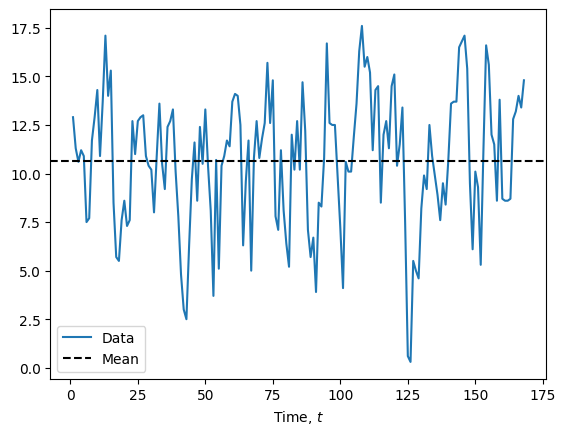

In [48]:
plt.figure()
plt.plot(*(data.T), label="Data")
plt.axhline(mean_press, ls="--", c="k", label="Mean")
plt.xlabel(r"Time, $t$")
plt.legend()
plt.show()

## Part e

In [49]:
# Fast Fourier transform of the data
fourier = sp.fft.fft(press - mean_press)  # Fourier transform, complex number
freqs = sp.fft.fftfreq(ndata)  # Fourier transform sample frequency
power_spectrum = np.abs(fourier) ** 2  # Power spectrum

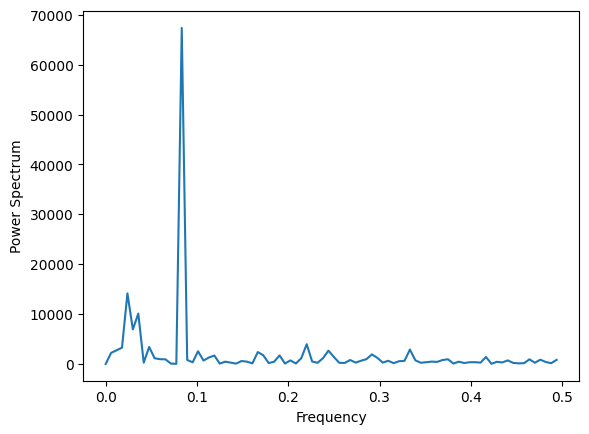

In [50]:
# Plot the power spectrum
sl = slice(0, int(ndata / 2))

plt.figure()
plt.plot(freqs[sl], power_spectrum[sl])
plt.xlabel("Frequency")
plt.ylabel("Power Spectrum")
plt.show()

In [51]:
# The 3 dominant peaks have power > 1e4
idx_peaks = np.where(power_spectrum[sl] > 1e4)[0]
freq_peaks = freqs[sl][idx_peaks]
period_peaks = 1 / freq_peaks

print("Peaks period:")
for f, T in zip(freq_peaks, period_peaks):
    print(f"Frequency: {f:0.3f}, Period: {T}")

Peaks period:
Frequency: 0.024, Period: 42.0
Frequency: 0.036, Period: 28.0
Frequency: 0.083, Period: 12.0


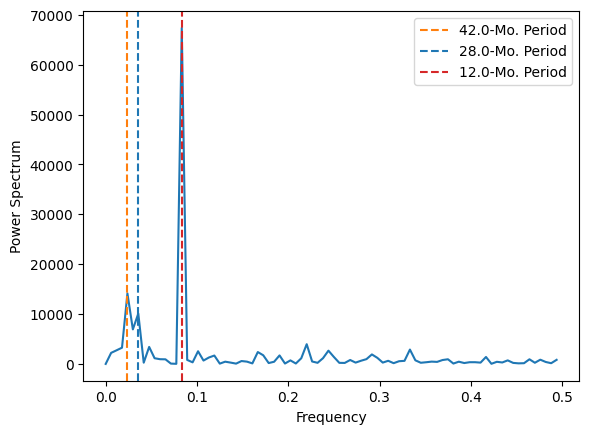

In [52]:
colors = ["tab:orange", "tab:blue", "tab:red"]

plt.figure()
plt.plot(freqs[sl], power_spectrum[sl])
for ii, f in enumerate(freq_peaks):
    plt.axvline(f, ls="--", c=colors[ii], label=f"{1/f}-Mo. Period")
plt.xlabel("Frequency")
plt.ylabel("Power Spectrum")
plt.legend()
plt.show()

## Part f

In [53]:
def y(theta, t=time):
    """Model"""
    th1, th2, th3, th4, th5, th6, th7, th8, th9 = theta

    term1 = th1
    term2 = th2 * np.cos(2 * np.pi * t / 12)
    term3 = th3 * np.sin(2 * np.pi * t / 12)
    term4 = th5 * np.cos(2 * np.pi * t / th4)
    term5 = th6 * np.sin(2 * np.pi * t / th4)
    term6 = th8 * np.cos(2 * np.pi * t / th7)
    term7 = th9 * np.sin(2 * np.pi * t / th7)
    return term1 + term2 + term3 + term4 + term5 + term6 + term7


def residuals(theta):
    """Residual"""
    return press - y(theta)

In [54]:
# Train the model
theta_init = np.array(  # Initial parameter guess
    [
        mean_press,
        std_press,
        std_press,
        period_peaks[0],
        std_press,
        std_press,
        period_peaks[1],
        std_press,
        std_press,
    ]
)

opt_res = opt.least_squares(residuals, theta_init, method="lm")
opt_res

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 4.381e-01 -6.630e-01 ... -2.988e-01  6.391e-01]
           x: [ 1.051e+01  3.076e+00  5.328e-01  4.431e+01 -1.623e+00
                5.256e-01  2.689e+01  2.124e-01  1.497e+00]
        cost: 394.26989385405125
         jac: [[-1.000e+00 -8.660e-01 ... -9.728e-01 -2.316e-01]
               [-1.000e+00 -5.000e-01 ... -8.928e-01 -4.505e-01]
               ...
               [-1.000e+00 -8.660e-01 ... -2.426e-01 -9.701e-01]
               [-1.000e+00 -1.000e+00 ... -1.132e-02 -9.999e-01]]
        grad: [-1.982e-08  8.467e-07 -3.222e-07  1.161e-03 -6.703e-04
               -2.071e-03  9.912e-03 -3.236e-03  4.627e-04]
  optimality: 0.009911683217320721
 active_mask: [0 0 0 0 0 0 0 0 0]
        nfev: 171
        njev: None

In [55]:
theta_best = opt_res.x
print("Best fit parameters:")
print(theta_best)

Best fit parameters:
[10.51075089  3.07621084  0.53279973 44.31121293 -1.62312733  0.52557742
 26.88775238  0.21244653  1.49666883]


## Part g

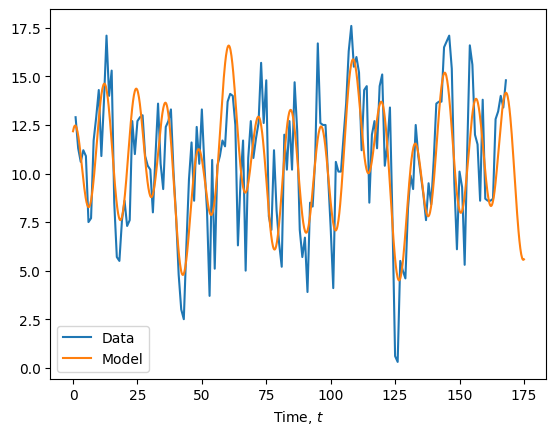

In [56]:
c

In [57]:
# Retrieve the Jacobian from the optimal solution
jac = opt_res.jac
# Sigma scaling
sigma2 = np.linalg.norm(opt_res.fun) ** 2 / (ndata - len(theta_best))
FIM = 1 / sigma2 * jac.T @ jac
# Parameter covariance
cov = np.linalg.inv(FIM)
# Parameter variance
var = np.diag(cov)
print("Parameter variance:")
print(var)

Parameter variance:
[0.03058591 0.05909786 0.05931509 0.89130834 0.07884226 0.23110624
 0.17316918 0.26481206 0.06469641]


In [59]:
np.linalg.norm(opt_res.fun)

28.080950619736907